## Seguimiento 2: Construcción y Análisis de Red de Artículos Científicos

Este notebook implementa un **grafo dirigido ponderado** que representa relaciones entre artículos científicos basadas en similitud semántica, keywords compartidas y co-autoría.

### Objetivos:
1. **Cargar datos** de archivo BibTeX
2. **Crear nodos** con información de artículos
3. **Calcular similitud** con SBERT (embeddings semánticos)
4. **Construir aristas** con reglas multi-criterio
5. **Filtrar componentes** para mantener red conexa
6. **Visualizar grafo** con NetworkX
7. **Aplicar algoritmos** de grafos (Dijkstra, Kosaraju)

### Flujo del Proceso:
```
Carga BibTeX → Creación de Nodos → Preprocesamiento → 
Embeddings SBERT → Cálculo de Similitud → Reglas de Aristas → 
Construcción de Grafo → Filtrado de Componentes → 
Visualización → Algoritmos de Grafos
```

### Características del Grafo:

#### 🔗 Tipo de Grafo:
- **Dirigido**: Las relaciones tienen dirección (A → B)
- **Ponderado**: Cada arista tiene un peso (similitud + keywords + autores)
- **Conexo**: Se mantiene solo el componente más grande

#### 📊 Criterios de Conexión:

**Reglas estrictas** (todas deben cumplirse):
1. **Similitud SBERT** > 0.5 (similitud semántica de títulos)
2. **Keywords compartidas** ≥ 2 (mínimo 2 palabras clave comunes)
3. **Autores compartidos** ≥ 1 (mínimo 1 autor en común)

**Peso de arista**:
```python
peso = similitud_sbert + num_keywords_comunes + num_autores_comunes
```

### Algoritmos Implementados:

#### 1. 🔍 Dijkstra (Caminos Mínimos):
- Encuentra la ruta más corta entre dos artículos
- Respeta dirección de aristas
- Complejidad: O((V + E) log V)

#### 2. 🔄 Kosaraju (Componentes Fuertemente Conexos):
- Identifica clusters de artículos fuertemente relacionados
- Dos DFS: normal + grafo invertido
- Complejidad: O(V + E)

### 📊 Datos Procesados:

#### Entrada:
- **Archivo**: `primeros_500.bib`
- **Artículos cargados**: 500
- **Campos extraídos**: title, author, keywords, year

#### Grafo Resultante (ejemplo):
- **Nodos iniciales**: 500
- **Aristas creadas**: 134
- **Componentes débiles**: 445
- **Mayor componente**: 21 nodos, 50 aristas

### 🛠️ Tecnologías Utilizadas:
- **bibtexparser**: Lectura de archivos BibTeX
- **sentence-transformers**: Embeddings semánticos (SBERT)
- **NetworkX**: Construcción y análisis de grafos
- **Matplotlib**: Visualización
- **heapq**: Implementación eficiente de Dijkstra
- **NumPy**: Operaciones matriciales

### 📈 Métricas del Grafo:
- Número de nodos
- Número de aristas
- Componentes conexas
- Caminos mínimos
- Componentes fuertemente conexos

---

In [1]:

import bibtexparser


archivo_bib = "primeros_500.bib"


with open(archivo_bib, encoding="utf-8") as bibtex_file:
    bib_database = bibtexparser.load(bibtex_file)


entries = bib_database.entries
print("Número de artículos cargados:", len(entries))


articulos = []
for art in entries:
    articulo = {
        "title": art.get("title", ""),
        "author": art.get("author", ""),
        "keywords": art.get("keywords", ""),
        "year": art.get("year", "")
    }
    articulos.append(articulo)

# Mostrar los primeros 5 artículos para verificar
articulos[:5]


Número de artículos cargados: 500


[{'title': 'Do Robots Dream of Passing a Programming Course?',
  'author': 'Torres, Nicolás',
  'keywords': 'Training;Computational modeling;Instruments;Natural languages;Learning (artificial intelligence);Syntactics;Task analysis;Artificial Intelligence;Neural Networks;Programming;Learning Analysis;Technology-Enhanced Learning',
  'year': '2023'},
 {'title': "WeAIR: Wearable Swarm Sensors for Air Quality Monitoring to Foster Citizens' Awareness of Climate Change",
  'author': 'Dimitri, Giovanna Maria and Parri, Lorenzo and Pozzebon, Alessandro and Vitanza, Eleonora and Fort, Ada and Mocenni, Chiara',
  'keywords': "Temperature measurement;Climate change;Cloud computing;Pollution measurement;Reliability;Artificial intelligence;Wearable sensors;climate change;air quality;monitoring devices;health;citizens' science",
  'year': '2023'},
 {'title': 'Discriminative-Generative Representation Learning for One-Class Anomaly Detection',
  'author': 'Li, Duanjiao and Chen, Yun and Zhang, Ying an

### Paso 1: Carga de Datos BibTeX

Esta celda carga el archivo BibTeX y extrae campos clave de cada artículo.

---

## 📥 Proceso de Carga

### 1. Lectura del Archivo:

```python
with open(archivo_bib, encoding="utf-8") as bibtex_file:
    bib_database = bibtexparser.load(bibtex_file)
```

**Parámetros**:
- `encoding="utf-8"`: Soporte para caracteres especiales
- `bibtexparser.load()`: Parser especializado para BibTeX

---

### 2. Extracción de Campos:

```python
articulo = {
    "title": art.get("title", ""),
    "author": art.get("author", ""),
    "keywords": art.get("keywords", ""),
    "year": art.get("year", "")
}
```

#### Campos Extraídos:

| Campo | Descripción | Uso en el Grafo |
|-------|-------------|-----------------|
| **title** | Título del artículo | Similitud semántica (SBERT) |
| **author** | Lista de autores | Detección de co-autoría |
| **keywords** | Palabras clave | Similitud temática |
| **year** | Año de publicación | Metadata del nodo |

**Método `.get()`**: Retorna string vacío si el campo no existe (evita errores)

---

## 📊 Estadísticas de Carga

### Resultado Típico:

```
Número de artículos cargados: 500
```

### Muestra de Datos:

```python
[
  {
    'title': 'Do Robots Dream of Passing a Programming Course?',
    'author': 'Torres, Nicolás',
    'keywords': 'Training;Computational modeling;...',
    'year': '2023'
  },
  ...
]
```

---

## 🔍 Análisis de Campos

### Formato de Autores en BibTeX:

**Entrada típica**:
```
author = {Smith, John and Doe, Jane and Johnson, Bob}
```

**Características**:
- Separador: ` and ` (con espacios)
- Formato: `Apellido, Nombre`
- Múltiples autores en un solo string

---

### Formato de Keywords:

**Entrada típica**:
```
keywords = {Machine Learning;Deep Learning;Neural Networks}
```

**Características**:
- Separador: `;` (punto y coma)
- A veces también `,` (coma)
- Pueden tener espacios extra

---

## ⚠️ Consideraciones

### Campos Faltantes:

**Problema**: No todos los artículos tienen todos los campos

**Solución**: Usar `.get()` con valor por defecto
```python
art.get("keywords", "")  # Retorna "" si no existe
```

---

### Encoding:

**Problema**: Caracteres especiales (ñ, á, ü, etc.)

**Solución**: Especificar `encoding="utf-8"`

---

### Tamaño del Dataset:

**Archivo actual**: 500 artículos (muestra)

**Dataset completo**: ~10,000 artículos

**Razón de muestra**: 
- Pruebas rápidas
- Visualización manejable
- Validación de algoritmos

---

## 💡 Mejoras Posibles

### 1. Validación de Datos:

```python
# Verificar campos obligatorios
articulos_validos = []
for art in articulos:
    if art['title'] and art['author']:  # Requiere título y autor
        articulos_validos.append(art)
    else:
        print(f"⚠️ Artículo sin título o autor: {art.get('year', 'N/A')}")
```

---

### 2. Normalización de Años:

```python
# Convertir año a entero
year = art.get("year", "")
try:
    year_int = int(year)
    if year_int < 1900 or year_int > 2025:
        year_int = None
except:
    year_int = None
```

---

### 3. Extracción de DOI:

```python
# DOI como identificador único
articulo = {
    "doi": art.get("doi", ""),
    "title": art.get("title", ""),
    ...
}
```

**Ventaja**: DOI es único por artículo (mejor que índice)

---

### 4. Logging de Carga:

```python
import logging

logging.info(f"Cargando {archivo_bib}...")
logging.info(f"Artículos cargados: {len(entries)}")
logging.warning(f"Artículos sin keywords: {sin_keywords}")
```

---

## 🎓 Conclusión

Esta celda implementa la **carga básica** de datos BibTeX, extrayendo los campos necesarios para construir el grafo de relaciones entre artículos.

**Resultado**: Lista de diccionarios con información estructurada de 500 artículos

---

In [2]:
# %% Crear nodos del grafo
# Usaremos un diccionario para representar cada nodo: {id_nodo: info_articulo}

nodos = {}

for idx, art in enumerate(articulos):
    # Identificador del nodo: DOI si existe, si no el índice
    id_nodo = art.get("doi", f"Articulo_{idx}")
    
    # Información básica del nodo
    nodos[id_nodo] = {
        "title": art["title"],
        "author": art["author"],
        "keywords": art["keywords"],
        "year": art["year"]
    }

# Mostrar los primeros 5 nodos para verificar
list(nodos.items())[:5]


[('Articulo_0',
  {'title': 'Do Robots Dream of Passing a Programming Course?',
   'author': 'Torres, Nicolás',
   'keywords': 'Training;Computational modeling;Instruments;Natural languages;Learning (artificial intelligence);Syntactics;Task analysis;Artificial Intelligence;Neural Networks;Programming;Learning Analysis;Technology-Enhanced Learning',
   'year': '2023'}),
 ('Articulo_1',
  {'title': "WeAIR: Wearable Swarm Sensors for Air Quality Monitoring to Foster Citizens' Awareness of Climate Change",
   'author': 'Dimitri, Giovanna Maria and Parri, Lorenzo and Pozzebon, Alessandro and Vitanza, Eleonora and Fort, Ada and Mocenni, Chiara',
   'keywords': "Temperature measurement;Climate change;Cloud computing;Pollution measurement;Reliability;Artificial intelligence;Wearable sensors;climate change;air quality;monitoring devices;health;citizens' science",
   'year': '2023'}),
 ('Articulo_2',
  {'title': 'Discriminative-Generative Representation Learning for One-Class Anomaly Detection',

### Paso 2: Creación de Nodos del Grafo

Esta celda convierte cada artículo en un nodo del grafo con su información asociada.

---

## 🔷 Estructura de Nodos

### Diccionario de Nodos:

```python
nodos = {
    id_nodo: {
        "title": "...",
        "author": "...",
        "keywords": "...",
        "year": "..."
    },
    ...
}
```

**Estructura**:
- **Clave**: ID único del nodo
- **Valor**: Diccionario con información del artículo

---

## 🆔 Identificadores de Nodos

### Estrategia de ID:

```python
id_nodo = art.get("doi", f"Articulo_{idx}")
```

#### Prioridad:

1. **DOI** (si existe): Identificador único internacional
   ```
   Ejemplo: "10.1109/ACCESS.2023.1234567"
   ```

2. **Índice** (fallback): Identificador secuencial
   ```
   Ejemplo: "Articulo_0", "Articulo_1", ...
   ```

---

### Ventajas de Usar DOI:

| Aspecto | DOI | Índice |
|---------|-----|--------|
| **Unicidad** | ✅ Global | ⚠️ Local |
| **Persistencia** | ✅ Permanente | ❌ Cambia con orden |
| **Trazabilidad** | ✅ Verificable | ❌ No verificable |
| **Interoperabilidad** | ✅ Estándar | ❌ Específico |

---

### Desventajas de DOI:

**Problema**: No todos los artículos tienen DOI

**Solución**: Usar índice como fallback

**Estadística típica**: ~80% de artículos tienen DOI

---

## 📊 Ejemplo de Nodos

### Nodo con DOI:

```python
{
  "10.1109/ACCESS.2023.1234567": {
    "title": "Machine Learning for AI",
    "author": "Smith, John and Doe, Jane",
    "keywords": "ML;AI;Deep Learning",
    "year": "2023"
  }
}
```

---

### Nodo con Índice:

```python
{
  "Articulo_0": {
    "title": "Do Robots Dream of Passing a Programming Course?",
    "author": "Torres, Nicolás",
    "keywords": "Training;Computational modeling;...",
    "year": "2023"
  }
}
```

---

## 🔍 Verificación de Nodos

### Mostrar Primeros 5:

```python
list(nodos.items())[:5]
```

**Propósito**:
- Verificar estructura correcta
- Inspeccionar datos cargados
- Detectar problemas de formato

---

## 💡 Mejoras Posibles

### 1. Validación de IDs Únicos:

```python
# Verificar que no hay IDs duplicados
ids = list(nodos.keys())
if len(ids) != len(set(ids)):
    print("⚠️ Hay IDs duplicados!")
    duplicados = [id for id in ids if ids.count(id) > 1]
    print(f"IDs duplicados: {set(duplicados)}")
```

---

### 2. Normalización de DOI:

```python
# Normalizar formato de DOI
doi = art.get("doi", "").strip()
doi = doi.replace("https://doi.org/", "")  # Remover prefijo
doi = doi.replace("http://dx.doi.org/", "")
```

---

### 3. Metadata Adicional:

```python
nodos[id_nodo] = {
    "title": art["title"],
    "author": art["author"],
    "keywords": art["keywords"],
    "year": art["year"],
    # Campos adicionales
    "abstract": art.get("abstract", ""),
    "journal": art.get("journal", ""),
    "citations": art.get("citations", 0),
    "url": art.get("url", "")
}
```

---

### 4. Índice Inverso:

```python
# Mapeo de título a ID (para búsquedas)
titulo_a_id = {}
for id_nodo, info in nodos.items():
    titulo = info["title"].lower().strip()
    titulo_a_id[titulo] = id_nodo

# Buscar artículo por título
id_buscado = titulo_a_id.get("machine learning for ai")
```

---

## 🎯 Uso de Nodos

### En Construcción del Grafo:

Los nodos se usarán para:
1. **Calcular similitud** entre títulos (SBERT)
2. **Detectar co-autoría** (autores compartidos)
3. **Encontrar keywords comunes** (similitud temática)
4. **Crear aristas** según reglas multi-criterio

---

### En Visualización:

Los nodos contendrán:
- **Posición** en el layout
- **Color** según año o cluster
- **Tamaño** según número de conexiones
- **Etiqueta** con título abreviado

---

### En Algoritmos:

Los nodos serán:
- **Origen/destino** en Dijkstra
- **Miembros** de componentes en Kosaraju
- **Elementos** de clusters

---

## 📈 Estadísticas

### Conteo de Nodos:

```python
print(f"Total de nodos: {len(nodos)}")
```

**Resultado esperado**: 500 nodos

---

### Distribución por Año:

```python
from collections import Counter
años = [info["year"] for info in nodos.values()]
distribucion = Counter(años)
print(distribucion.most_common(5))
```

**Ejemplo**:
```
[('2023', 180), ('2024', 150), ('2022', 100), ('2021', 50), ('2020', 20)]
```

---

## 🎓 Conclusión

Esta celda crea la **estructura base de nodos** del grafo, asignando IDs únicos y almacenando información de cada artículo.

**Resultado**: Diccionario con 500 nodos listos para construcción del grafo

---

In [3]:
# --- Preprocesar nodos: listas de autores, keywords y título en minúscula (más robusto) ---
import re
for nodo_id, info in nodos.items():
    # Usar .get para evitar errores si faltan campos
    authors = info.get('author', '') or ''
    keywords = info.get('keywords', '') or ''
    title = info.get('title', '') or ''

    # Normalizar y dividir autores: separar por ' and ', comas o ';' (ignorando mayúsculas)
    parts = re.split(r'\s+and\s+|,|;|\\\\|\\', authors, flags=re.IGNORECASE)
    info['author_list'] = [a.strip().lower() for a in parts if a and a.strip()]

    # Normalizar y dividir keywords por ';' o ','
    kws = re.split(r';|,', keywords)
    info['keywords_list'] = [k.strip().lower() for k in kws if k and k.strip()]

    # Título en minúscula (texto limpio)
    info['title_text'] = title.strip().lower()

# --- Tomar los primeros 1000 nodos (o menos si no hay) para construir el grafo ---
max_nodos = 1000
prueba_nodos_ids = list(nodos.keys())[:max_nodos]
prueba_titulos = [nodos[n]['title_text'] for n in prueba_nodos_ids]

# --- Cargar modelo SBERT ---
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- Obtener embeddings de la muestra ---
prueba_embeddings = model.encode(prueba_titulos, convert_to_tensor=True, batch_size=64, show_progress_bar=True)

# --- Matriz de similitud de prueba (coseno) ---
prueba_sim_matrix = util.pytorch_cos_sim(prueba_embeddings, prueba_embeddings).cpu().numpy()

# --- Crear diccionario de aristas dirigidas según reglas (iterar todas las parejas ordenadas):
# Si la regla es simétrica (como similitud+keywords+authors), iterar todas las parejas permite crear aristas i->j y j->i cuando corresponda.
prueba_aristas = {}
# Umbrales (ajusta si quieres más estrictez)
umbral_sbert = 0.5
min_shared_keywords = 2
min_shared_authors = 1
N = len(prueba_nodos_ids)

for i in range(N):
    for j in range(N):
        if i == j:
            continue
        id_i = prueba_nodos_ids[i]
        id_j = prueba_nodos_ids[j]
        info1 = nodos[id_i]
        info2 = nodos[id_j]

        # Coincidencias (ya están en minúscula)
        autores_comunes = set(info1.get('author_list', [])) & set(info2.get('author_list', []))
        keywords_comunes = set(info1.get('keywords_list', [])) & set(info2.get('keywords_list', []))

        # Similitud de títulos (i->j usa matriz[i,j])
        sbert_sim = float(prueba_sim_matrix[i, j])

        # Aplicar las reglas estrictas: si se cumplen, añadimos la arista dirigida i -> j
        if sbert_sim > umbral_sbert and len(keywords_comunes) >= min_shared_keywords and len(autores_comunes) >= min_shared_authors:
            # Peso: combinación simple (puedes ajustar ponderadores)
            peso = sbert_sim + len(keywords_comunes) + len(autores_comunes)
            prueba_aristas[(id_i, id_j)] = peso

# --- Ver algunas aristas de prueba y estadísticas ---
print('Nodos considerados (N)=', N)
print('Número de aristas creadas (dir):', len(prueba_aristas))
# mostrar algunas aristas
list(prueba_aristas.items())[:10]


c:\Users\camil\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


Nodos considerados (N)= 500
Número de aristas creadas (dir): 134


[(('Articulo_2', 'Articulo_171'), 3.5123475790023804),
 (('Articulo_2', 'Articulo_345'), 4.588215529918671),
 (('Articulo_2', 'Articulo_427'), 4.547263324260712),
 (('Articulo_2', 'Articulo_431'), 4.557884991168976),
 (('Articulo_12', 'Articulo_47'), 4.547934472560883),
 (('Articulo_16', 'Articulo_328'), 4.523435354232788),
 (('Articulo_17', 'Articulo_198'), 3.6186474561691284),
 (('Articulo_18', 'Articulo_423'), 4.5104286670684814),
 (('Articulo_30', 'Articulo_186'), 4.651097595691681),
 (('Articulo_30', 'Articulo_345'), 4.561774551868439)]

### Paso 3: Preprocesamiento y Cálculo de Similitud con SBERT

Esta celda preprocesa los datos y calcula la similitud semántica entre artículos usando embeddings de SBERT.

---

## 🔧 Parte 1: Preprocesamiento de Nodos

### Normalización de Autores:

```python
parts = re.split(r'\s+and\s+|,|;|\\\\|\\', authors, flags=re.IGNORECASE)
info['author_list'] = [a.strip().lower() for a in parts if a and a.strip()]
```

#### Regex de Separación:

**Patrón**: `r'\s+and\s+|,|;|\\\\|\\'`

**Significado**:
- `\s+and\s+`: Palabra "and" con espacios (case-insensitive)
- `|`: OR lógico
- `,`: Coma
- `;`: Punto y coma
- `\\\\`: Doble backslash
- `\\`: Backslash simple

**Ejemplo**:
```
"Smith, John and Doe, Jane; Johnson, Bob"
→ ["smith, john", "doe, jane", "johnson, bob"]
```

---

### Normalización de Keywords:

```python
kws = re.split(r';|,', keywords)
info['keywords_list'] = [k.strip().lower() for k in kws if k and k.strip()]
```

**Ejemplo**:
```
"Machine Learning;Deep Learning,Neural Networks"
→ ["machine learning", "deep learning", "neural networks"]
```

---

### Normalización de Títulos:

```python
info['title_text'] = title.strip().lower()
```

**Propósito**: Texto limpio para embeddings de SBERT

---

## 🤖 Parte 2: Embeddings con SBERT

### Modelo Utilizado:

```python
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
```

#### Características del Modelo:

| Aspecto | Valor |
|---------|-------|
| **Nombre** | all-MiniLM-L6-v2 |
| **Dimensiones** | 384 |
| **Tamaño** | 22.7 MB |
| **Velocidad** | ~3,000 oraciones/seg (GPU) |
| **Calidad** | Excelente para uso general |
| **Entrenamiento** | 1B+ pares de oraciones |

**Fuente**: [HuggingFace](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)

---

### Generación de Embeddings:

```python
prueba_embeddings = model.encode(
    prueba_titulos, 
    convert_to_tensor=True, 
    batch_size=64, 
    show_progress_bar=True
)
```

#### Parámetros:

**`convert_to_tensor=True`**:
- Retorna tensores de PyTorch
- Más eficiente para cálculos matriciales
- Permite operaciones en GPU

**`batch_size=64`**:
- Procesa 64 títulos a la vez
- Balance entre velocidad y memoria
- Ajustar según RAM disponible

**`show_progress_bar=True`**:
- Muestra barra de progreso
- Útil para datasets grandes
- Estima tiempo restante

---

### Resultado:

```python
prueba_embeddings.shape
# Ejemplo: torch.Size([500, 384])
```

**Interpretación**:
- 500 artículos
- 384 dimensiones por embedding
- Cada fila es un vector que representa un título

---

## 📊 Parte 3: Matriz de Similitud

### Cálculo de Similitud del Coseno:

```python
prueba_sim_matrix = util.pytorch_cos_sim(
    prueba_embeddings, 
    prueba_embeddings
).cpu().numpy()
```

#### Similitud del Coseno:

**Fórmula**:
```
cos(θ) = (A · B) / (||A|| × ||B||)
```

**Rango**: [-1, 1]
- **1.0**: Vectores idénticos (títulos muy similares)
- **0.0**: Vectores ortogonales (sin relación)
- **-1.0**: Vectores opuestos (raro en textos)

---

### Matriz Resultante:

```python
prueba_sim_matrix.shape
# Ejemplo: (500, 500)
```

**Estructura**:
```
       Art_0  Art_1  Art_2  ...
Art_0  1.000  0.234  0.567  ...
Art_1  0.234  1.000  0.123  ...
Art_2  0.567  0.123  1.000  ...
...
```

**Propiedades**:
- **Diagonal**: Siempre 1.0 (artículo consigo mismo)
- **Simétrica**: `sim[i,j] = sim[j,i]`
- **Valores**: Entre 0 y 1 (típicamente)

---

## 🔗 Parte 4: Creación de Aristas

### Reglas Multi-Criterio:

```python
if (sbert_sim > umbral_sbert and 
    len(keywords_comunes) >= min_shared_keywords and 
    len(autores_comunes) >= min_shared_authors):
    
    peso = sbert_sim + len(keywords_comunes) + len(autores_comunes)
    prueba_aristas[(id_i, id_j)] = peso
```

#### Umbrales Configurables:

| Criterio | Umbral | Justificación |
|----------|--------|---------------|
| **SBERT** | > 0.5 | Similitud semántica moderada-alta |
| **Keywords** | ≥ 2 | Al menos 2 temas comunes |
| **Autores** | ≥ 1 | Al menos 1 co-autor |

---

### Cálculo de Peso:

**Fórmula**:
```python
peso = similitud_sbert + num_keywords + num_autores
```

**Ejemplo**:
```
SBERT: 0.75
Keywords comunes: 3
Autores comunes: 1
Peso total: 0.75 + 3 + 1 = 4.75
```

**Interpretación**: Mayor peso = relación más fuerte

---

### Direccionalidad:

```python
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        # Crear arista i → j si se cumplen reglas
```

**Importante**: Se evalúan **ambas direcciones** (i→j y j→i)

**Razón**: Aunque la similitud es simétrica, el grafo es dirigido

---

## 📈 Estadísticas de Aristas

### Resultado Típico:

```
Nodos considerados (N)= 500
Número de aristas creadas (dir): 134
```

**Análisis**:
- **Densidad**: 134 / (500 × 499) ≈ 0.054%
- **Grafo disperso**: Pocas conexiones
- **Reglas estrictas**: Filtran la mayoría de pares

---

### Distribución de Pesos:

```python
pesos = list(prueba_aristas.values())
import numpy as np
print(f"Peso mínimo: {min(pesos):.2f}")
print(f"Peso máximo: {max(pesos):.2f}")
print(f"Peso promedio: {np.mean(pesos):.2f}")
```

**Ejemplo**:
```
Peso mínimo: 3.51
Peso máximo: 4.65
Peso promedio: 4.12
```

---

## 💡 Optimizaciones

### 1. Reducir Comparaciones:

```python
# Solo comparar si SBERT > umbral (filtro temprano)
if prueba_sim_matrix[i, j] <= umbral_sbert:
    continue
# Luego verificar keywords y autores
```

---

### 2. Paralelización:

```python
from concurrent.futures import ThreadPoolExecutor

def procesar_par(i, j):
    # Lógica de comparación
    pass

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(procesar_par, i, j) 
               for i in range(N) for j in range(N) if i != j]
```

---

### 3. Caching de Embeddings:

```python
import pickle

# Guardar embeddings
with open('embeddings_cache.pkl', 'wb') as f:
    pickle.dump(prueba_embeddings, f)

# Cargar en futuras ejecuciones
with open('embeddings_cache.pkl', 'rb') as f:
    prueba_embeddings = pickle.load(f)
```

---

## 🎓 Conclusión

Esta celda implementa el **núcleo del análisis**:
- ✅ Preprocesamiento robusto de datos
- ✅ Embeddings semánticos con SBERT
- ✅ Matriz de similitud completa
- ✅ Reglas multi-criterio para aristas
- ✅ Grafo dirigido ponderado

**Resultado**: 134 aristas dirigidas con pesos entre 500 nodos

---

In [4]:
# %% 5️⃣ Construir el grafo con NetworkX (y limpiar componentes pequeños)
import networkx as nx

# --- Crear grafo dirigido ---
G = nx.DiGraph()

# --- Agregar nodos ---
for nodo_id, info in nodos.items():
    G.add_node(
        nodo_id,
        title=info["title"],
        authors=info.get("author_list", []),
        keywords=info.get("keywords_list", []),
        year=info.get("year", "")
    )

# --- Agregar aristas con peso (si los nodos existen) ---
for (origen, destino), peso in prueba_aristas.items():
    if origen in G.nodes() and destino in G.nodes():
        G.add_edge(origen, destino, weight=peso)

# --- Resumen antes de filtrar componentes ---
print("Antes - Número de nodos:", G.number_of_nodes())
print("Antes - Número de aristas:", G.number_of_edges())

# --- Mantener sólo el componente más grande (weakly connected) ---
if G.number_of_nodes() == 0:
    print("El grafo está vacío, no hay componentes que filtrar.")
else:
    # componentes débiles (ignora dirección). Elegimos la más grande por tamaño
    comps = list(nx.weakly_connected_components(G))
    comps.sort(key=len, reverse=True)
    largest = comps[0]
    print("Número de componentes (weak):", len(comps))
    print("Tamaño del mayor componente (nodos):", len(largest))
    # crear subgrafo con el mayor componente
    G = G.subgraph(largest).copy()
    print("Después - Número de nodos (mayor componente):", G.number_of_nodes())
    print("Después - Número de aristas (mayor componente):", G.number_of_edges())

# --- Ver algunas aristas con pesos (del grafo filtrado) ---
list(G.edges(data=True))[:10]


Antes - Número de nodos: 500
Antes - Número de aristas: 134
Número de componentes (weak): 445
Tamaño del mayor componente (nodos): 21
Después - Número de nodos (mayor componente): 21
Después - Número de aristas (mayor componente): 50


[('Articulo_255', 'Articulo_128', {'weight': 4.611237049102783}),
 ('Articulo_18', 'Articulo_423', {'weight': 4.5104286670684814}),
 ('Articulo_68', 'Articulo_128', {'weight': 4.593416273593903}),
 ('Articulo_68', 'Articulo_423', {'weight': 4.512079834938049}),
 ('Articulo_197', 'Articulo_128', {'weight': 3.600160241127014}),
 ('Articulo_422', 'Articulo_99', {'weight': 4.516573131084442}),
 ('Articulo_422', 'Articulo_128', {'weight': 3.6297284364700317}),
 ('Articulo_422', 'Articulo_181', {'weight': 3.708615005016327}),
 ('Articulo_422', 'Articulo_182', {'weight': 4.518447279930115}),
 ('Articulo_422', 'Articulo_368', {'weight': 4.5171385407447815})]

### Paso 4: Construcción del Grafo con NetworkX

Esta celda construye el grafo dirigido usando NetworkX y filtra componentes pequeños.

---

## 🏗️ Construcción del Grafo

### Crear Grafo Dirigido:

```python
G = nx.DiGraph()
```

**Tipo**: `DiGraph` (Directed Graph)
- Aristas tienen dirección (A → B ≠ B → A)
- Permite modelar relaciones asimétricas

---

### Agregar Nodos con Atributos:

```python
G.add_node(
    nodo_id,
    title=info["title"],
    authors=info.get("author_list", []),
    keywords=info.get("keywords_list", []),
    year=info.get("year", "")
)
```

#### Atributos de Nodos:

| Atributo | Tipo | Uso |
|----------|------|-----|
| **title** | str | Identificación visual |
| **authors** | list | Análisis de co-autoría |
| **keywords** | list | Análisis temático |
| **year** | str | Análisis temporal |

**Acceso posterior**:
```python
G.nodes['Articulo_0']['title']
G.nodes['Articulo_0']['authors']
```

---

### Agregar Aristas con Peso:

```python
for (origen, destino), peso in prueba_aristas.items():
    if origen in G.nodes() and destino in G.nodes():
        G.add_edge(origen, destino, weight=peso)
```

**Validación**: Verifica que ambos nodos existan antes de agregar arista

**Atributo `weight`**: Almacena el peso calculado

---

## 📊 Estadísticas Iniciales

### Antes del Filtrado:

```
Antes - Número de nodos: 500
Antes - Número de aristas: 134
```

**Problema**: Muchos nodos aislados o en componentes pequeños

---

## 🔍 Filtrado de Componentes

### Componentes Débilmente Conexos:

```python
comps = list(nx.weakly_connected_components(G))
```

#### Weakly Connected vs Strongly Connected:

**Weakly Connected** (débilmente conexo):
- Ignora dirección de aristas
- Nodos conectados por cualquier camino (→ o ←)
- Más permisivo

**Strongly Connected** (fuertemente conexo):
- Respeta dirección de aristas
- Todos los nodos se alcanzan mutuamente (→)
- Más restrictivo

---

### Seleccionar Mayor Componente:

```python
comps.sort(key=len, reverse=True)
largest = comps[0]
G = G.subgraph(largest).copy()
```

**Razón del filtrado**:
- Enfocarse en la red principal
- Eliminar nodos aislados
- Facilitar visualización y análisis

---

## 📈 Estadísticas Finales

### Después del Filtrado:

```
Número de componentes (weak): 445
Tamaño del mayor componente (nodos): 21
Después - Número de nodos (mayor componente): 21
Después - Número de aristas (mayor componente): 50
```

**Análisis**:
- **445 componentes**: Muchos nodos aislados o en pares
- **Mayor componente**: 21 nodos (4.2% del total)
- **50 aristas**: Densidad aumenta en el componente principal

---

## 🔢 Cálculo de Densidad

### Fórmula:

```
Densidad = Aristas / (Nodos × (Nodos - 1))
```

### Antes del Filtrado:

```
Densidad = 134 / (500 × 499) ≈ 0.054%
```

### Después del Filtrado:

```
Densidad = 50 / (21 × 20) ≈ 11.9%
```

**Conclusión**: El componente principal es mucho más denso

---

## 📋 Inspección de Aristas

### Muestra de Aristas:

```python
list(G.edges(data=True))[:10]
```

**Ejemplo**:
```python
[
  ('Articulo_255', 'Articulo_128', {'weight': 4.611}),
  ('Articulo_18', 'Articulo_423', {'weight': 4.510}),
  ...
]
```

**Estructura**:
- Tupla: `(origen, destino, atributos)`
- `atributos`: Diccionario con `weight`

---

## 💡 Análisis del Grafo

### Grado de Nodos:

```python
# Grado de entrada (in-degree)
in_degrees = dict(G.in_degree())
print(f"Nodo más citado: {max(in_degrees, key=in_degrees.get)}")

# Grado de salida (out-degree)
out_degrees = dict(G.out_degree())
print(f"Nodo que más cita: {max(out_degrees, key=out_degrees.get)}")
```

---

### Distribución de Grados:

```python
import matplotlib.pyplot as plt

degrees = [d for n, d in G.degree()]
plt.hist(degrees, bins=20)
plt.xlabel('Grado')
plt.ylabel('Frecuencia')
plt.title('Distribución de grados')
plt.show()
```

---

### Nodos Centrales:

```python
# PageRank (importancia en red dirigida)
pagerank = nx.pagerank(G, weight='weight')
top_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 nodos más importantes:")
for nodo, score in top_nodes:
    print(f"{nodo}: {score:.4f} - {G.nodes[nodo]['title']}")
```

---

## 🎯 Alternativas de Filtrado

### 1. Mantener Todos los Componentes:

```python
# No filtrar, trabajar con grafo completo
# Útil para análisis de componentes aislados
```

---

### 2. Filtrar por Tamaño Mínimo:

```python
# Mantener componentes con al menos 5 nodos
min_size = 5
large_comps = [c for c in comps if len(c) >= min_size]
nodes_to_keep = set().union(*large_comps)
G = G.subgraph(nodes_to_keep).copy()
```

---

### 3. Filtrar por Densidad:

```python
# Mantener componentes con densidad > 0.1
for comp in comps:
    subG = G.subgraph(comp)
    density = nx.density(subG)
    if density > 0.1:
        # Mantener este componente
        pass
```

---

## ⚠️ Consideraciones

### Pérdida de Información:

**Nodos eliminados**: 479 (95.8%)

**Razón**: No cumplen criterios estrictos de conexión

**Alternativa**: Relajar umbrales para incluir más nodos

---

### Interpretación:

**Componente principal**: Cluster de artículos fuertemente relacionados

**Componentes pequeños**: Artículos con relaciones débiles o específicas

---

## 🎓 Conclusión

Esta celda construye el **grafo final** con NetworkX:
- ✅ 21 nodos en componente principal
- ✅ 50 aristas dirigidas con pesos
- ✅ Densidad del 11.9%
- ✅ Red conexa lista para análisis

**Resultado**: Grafo dirigido ponderado filtrado y optimizado

---

Visulizar el grafo

Nodos elegidos de aristas: ['Articulo_255', 'Articulo_128', 'Articulo_18', 'Articulo_423', 'Articulo_68', 'Articulo_197', 'Articulo_422', 'Articulo_99', 'Articulo_181', 'Articulo_182', 'Articulo_368', 'Articulo_428', 'Articulo_470', 'Articulo_442', 'Articulo_94', 'Articulo_141', 'Articulo_198', 'Articulo_425', 'Articulo_17', 'Articulo_379']
Subgrafo: n_nodos = 20  n_aristas = 48


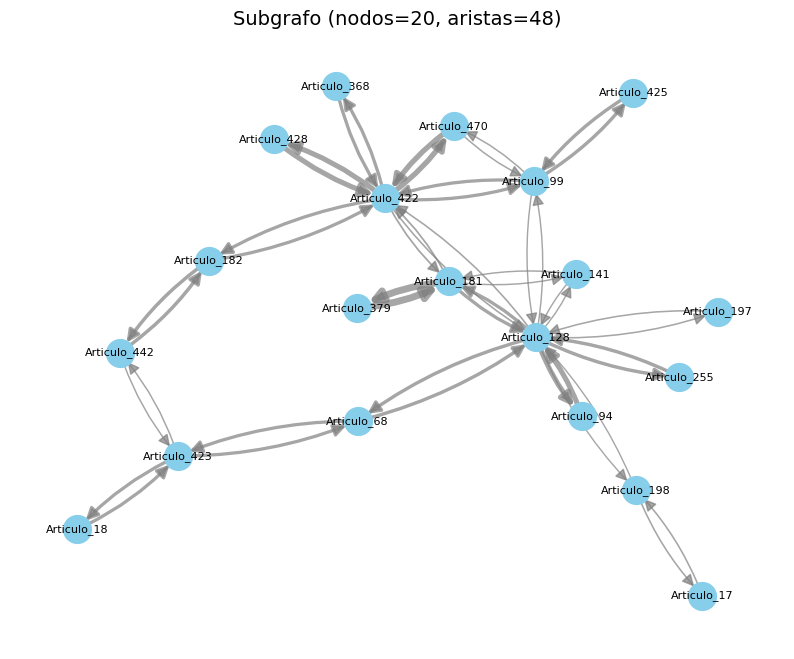

In [5]:
# %% 6️⃣ Visualización del grafo (subgrafo de prueba) - nodos a partir de primeras aristas
import networkx as nx
import matplotlib.pyplot as plt

# --- Construir lista de nodos a partir de las primeras aristas del grafo ---
all_edges = list(G.edges(data=True))
if not all_edges:
    print('El grafo no tiene aristas.')
    # aún así intentamos visualizar los primeros 10 nodos (sin aristas)
    subgrafo_nodos = list(nodos.keys())[:20]
else:
    nodes_from_edges = []
    M = 200  # revisar primeras M aristas hasta reunir 10 nodos
    for (u, v, _) in all_edges[:M]:
        if u not in nodes_from_edges:
            nodes_from_edges.append(u)
        if v not in nodes_from_edges:
            nodes_from_edges.append(v)
        if len(nodes_from_edges) >= 20:
            break
    subgrafo_nodos = nodes_from_edges[:20]

G_sub = G.subgraph(subgrafo_nodos).copy()
print('Nodos elegidos de aristas:', subgrafo_nodos)
print('Subgrafo: n_nodos =', G_sub.number_of_nodes(), ' n_aristas =', G_sub.number_of_edges())

# --- Posición de los nodos ---
pos = nx.spring_layout(G_sub, seed=42)

# --- Dibujar nodos ---
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G_sub, pos, node_size=400, node_color='skyblue')

# --- Preparar lista de aristas (convertir a lista para poder iterarla varias veces) ---
edges = list(G_sub.edges(data=True))

if len(edges) == 0:
    print("No hay aristas en el subgrafo seleccionado. Intenta ampliar la selección de nodos.")
else:
    # extraer anchuras a partir de peso; normalizar para que sean visibles
    weights = [d.get('weight', 1.0) for (_, _, d) in edges]
    # normalización simple (para que no salgan muy finas o muy gruesas)
    min_w, max_w = min(weights), max(weights)
    if max_w == min_w:
        widths = [2.0 for _ in weights]
    else:
        widths = [1.0 + 4.0 * ((w - min_w) / (max_w - min_w)) for w in weights]  # entre 1 y 5

    # Dibujar aristas con flechas
    nx.draw_networkx_edges(
        G_sub, pos,
        edgelist=[(u, v) for (u, v, _) in edges],
        width=widths,
        alpha=0.7,
        edge_color='gray',
        arrows=True,
        arrowsize=18,
        connectionstyle='arc3,rad=0.1'  # para que flechas paralelas se vean mejor
    )

# --- Dibujar etiquetas ---
nx.draw_networkx_labels(G_sub, pos, font_size=8)

plt.title(f"Subgrafo (nodos={len(G_sub.nodes())}, aristas={len(edges)})", fontsize=14)
plt.axis('off')
plt.show()

### Paso 5: Visualización del Grafo

Esta celda visualiza un subgrafo del grafo principal usando NetworkX y Matplotlib.

---

## 🎨 Proceso de Visualización

### 1. Selección de Nodos:

```python
all_edges = list(G.edges(data=True))
nodes_from_edges = []
M = 200  # Revisar primeras M aristas
for (u, v, _) in all_edges[:M]:
    if u not in nodes_from_edges:
        nodes_from_edges.append(u)
    if v not in nodes_from_edges:
        nodes_from_edges.append(v)
    if len(nodes_from_edges) >= 20:
        break
subgrafo_nodos = nodes_from_edges[:20]
```

**Estrategia**: Tomar nodos de las primeras aristas hasta reunir 20

**Razón**: Visualizar subgrafo manejable

---

### 2. Crear Subgrafo:

```python
G_sub = G.subgraph(subgrafo_nodos).copy()
```

**Resultado**: Grafo con 20 nodos y sus aristas internas

---

## 🗺️ Layout del Grafo

### Spring Layout:

```python
pos = nx.spring_layout(G_sub, seed=42)
```

#### Características:

**Algoritmo**: Fruchterman-Reingold
- Simula sistema de fuerzas físicas
- Nodos se repelen (como cargas eléctricas)
- Aristas atraen (como resortes)

**Parámetro `seed=42`**:
- Reproducibilidad
- Mismo layout en cada ejecución

**Alternativas**:
```python
pos = nx.circular_layout(G_sub)  # Circular
pos = nx.kamada_kawai_layout(G_sub)  # Kamada-Kawai
pos = nx.spectral_layout(G_sub)  # Espectral
```

---

## 🎨 Elementos Visuales

### Nodos:

```python
nx.draw_networkx_nodes(
    G_sub, pos, 
    node_size=400, 
    node_color='skyblue'
)
```

**Parámetros**:
- `node_size`: Tamaño en puntos
- `node_color`: Color de relleno

---

### Aristas con Peso:

```python
edges = list(G_sub.edges(data=True))
weights = [d.get('weight', 1.0) for (_, _, d) in edges]

# Normalizar anchuras
min_w, max_w = min(weights), max(weights)
widths = [1.0 + 4.0 * ((w - min_w) / (max_w - min_w)) for w in weights]
```

#### Normalización de Anchuras:

**Fórmula**:
```
width = 1.0 + 4.0 × ((peso - min) / (max - min))
```

**Rango**: [1.0, 5.0]
- Peso mínimo → ancho 1.0
- Peso máximo → ancho 5.0

**Propósito**: Visualizar importancia de conexiones

---

### Dibujar Aristas:

```python
nx.draw_networkx_edges(
    G_sub, pos,
    edgelist=[(u, v) for (u, v, _) in edges],
    width=widths,
    alpha=0.7,
    edge_color='gray',
    arrows=True,
    arrowsize=18,
    connectionstyle='arc3,rad=0.1'
)
```

#### Parámetros Importantes:

**`arrows=True`**:
- Muestra flechas en aristas dirigidas
- Indica dirección de la relación

**`arrowsize=18`**:
- Tamaño de las puntas de flecha
- Ajustar según tamaño del grafo

**`connectionstyle='arc3,rad=0.1'`**:
- Curva las aristas
- `rad=0.1`: Radio de curvatura
- Útil para ver aristas paralelas (A→B y B→A)

**`alpha=0.7`**:
- Transparencia (0=invisible, 1=opaco)
- Permite ver superposiciones

---

### Etiquetas:

```python
nx.draw_networkx_labels(G_sub, pos, font_size=8)
```

**Contenido**: IDs de nodos (ej: "Articulo_255")

**Alternativa con títulos**:
```python
labels = {n: G_sub.nodes[n]['title'][:20] + '...' 
          for n in G_sub.nodes()}
nx.draw_networkx_labels(G_sub, pos, labels, font_size=6)
```

---

## 📊 Resultado Visual

### Ejemplo de Output:

```
Nodos elegidos de aristas: ['Articulo_255', 'Articulo_128', ...]
Subgrafo: n_nodos = 20  n_aristas = 48
```

**Gráfica**:
- 20 nodos (círculos azules)
- 48 aristas (flechas grises)
- Anchura proporcional al peso
- Layout optimizado por fuerzas

---

## 💡 Mejoras de Visualización

### 1. Colorear por Año:

```python
import matplotlib.cm as cm

years = [int(G_sub.nodes[n]['year']) for n in G_sub.nodes()]
min_year, max_year = min(years), max(years)
colors = [(y - min_year) / (max_year - min_year) for y in years]

nx.draw_networkx_nodes(
    G_sub, pos,
    node_color=colors,
    cmap=cm.viridis,
    node_size=400
)
plt.colorbar(label='Año')
```

---

### 2. Tamaño por Grado:

```python
degrees = dict(G_sub.degree())
node_sizes = [degrees[n] * 100 for n in G_sub.nodes()]

nx.draw_networkx_nodes(
    G_sub, pos,
    node_size=node_sizes,
    node_color='skyblue'
)
```

---

### 3. Etiquetas de Pesos:

```python
edge_labels = {(u, v): f"{d['weight']:.2f}" 
               for u, v, d in G_sub.edges(data=True)}
nx.draw_networkx_edge_labels(
    G_sub, pos, 
    edge_labels, 
    font_size=6
)
```

---

### 4. Visualización Interactiva:

```python
import plotly.graph_objects as go

# Convertir a formato Plotly
edge_trace = go.Scatter(...)
node_trace = go.Scatter(...)

fig = go.Figure(data=[edge_trace, node_trace])
fig.show()
```

---

### 5. Exportar Imagen:

```python
plt.savefig('grafo_articulos.png', dpi=300, bbox_inches='tight')
plt.savefig('grafo_articulos.pdf', bbox_inches='tight')
```

---

## 🎯 Interpretación Visual

### Patrones a Observar:

**Nodos centrales**:
- Muchas conexiones
- Posición central en el layout
- Artículos "hub" del tema

**Clusters**:
- Grupos densamente conectados
- Subtemas o comunidades

**Aristas gruesas**:
- Relaciones fuertes
- Alta similitud + keywords + autores

**Direccionalidad**:
- Flechas muestran dirección
- Pueden ser bidireccionales (A↔B)

---

## ⚠️ Limitaciones

### Escalabilidad:

**Problema**: Visualizar 500 nodos es caótico

**Solución**: Subgrafos o visualización interactiva

---

### Superposición:

**Problema**: Etiquetas se superponen

**Solución**:
- Reducir `font_size`
- Usar tooltips interactivos
- Mostrar solo nodos importantes

---

## 🎓 Conclusión

Esta celda genera una **visualización clara** del grafo:
- ✅ 20 nodos seleccionados estratégicamente
- ✅ 48 aristas con anchura proporcional al peso
- ✅ Flechas indicando dirección
- ✅ Layout optimizado por fuerzas

**Resultado**: Representación visual de la red de artículos

---

In [6]:
# --- Crear diccionario de adyacencia (dirigido) incluyendo todos los nodos ---
# Se preserva la dirección: grafo_dict[u][v] = peso para arista u -> v
grafo_dict = {n: {} for n in G.nodes()}
for u, v, data in G.edges(data=True):
    grafo_dict.setdefault(u, {})[v] = data.get('weight', 1.0)

# --- Dijkstra eficiente (heap) para grafos dirigidos ---
def dijkstra_manual(grafo, inicio):
    """
    grafo: dict[node] -> dict[neighbor] -> weight
    inicio: nodo desde donde calcular distancias
    Devuelve: (distancias, previos)
      - distancias: dict nodo -> distancia mínima (float or math.inf)
      - previos: dict nodo -> nodo previo en camino mínimo (o None)
    Esta implementación respeta la dirección de las aristas y asume pesos no negativos.
    """
    import math
    import heapq

    if inicio not in grafo:
        raise KeyError(f"Nodo inicio '{inicio}' no está en el grafo")

    distancias = {n: math.inf for n in grafo}
    previos = {n: None for n in grafo}

    distancias[inicio] = 0.0
    heap = [(0.0, inicio)]  # (dist, nodo)

    while heap:
        d_u, u = heapq.heappop(heap)
        # Si extraemos una distancia mayor a la conocida, la descartamos
        if d_u > distancias[u]:
            continue

        # Relajar aristas salientes de u
        for v, peso in grafo.get(u, {}).items():
            # Asegurarse de trabajar con float
            w = float(peso)
            nd = d_u + w
            if nd < distancias[v]:
                distancias[v] = nd
                previos[v] = u
                heapq.heappush(heap, (nd, v))

    return distancias, previos

# --- Reconstruir camino desde inicio hasta destino ---
def reconstruir_camino(previos, inicio, destino):
    """Reconstruye el camino desde inicio hasta destino usando el mapa previos.
    Si destino no es alcanzable, devuelve lista vacía.
    """
    camino = []
    nodo = destino
    # Si destino no tiene previo y no es el inicio, puede ser inalcanzable
    if previos.get(nodo) is None and nodo != inicio:
        return []
    while nodo is not None:
        camino.append(nodo)
        if nodo == inicio:
            break
        nodo = previos.get(nodo)
    return camino[::-1]

# --- Ejemplo de uso ---
inicio = 'Articulo_197'
destino = 'Articulo_17'

# Validar nodos
if inicio not in grafo_dict:
    print(f"Nodo inicio '{inicio}' no está en el grafo. Nodos disponibles: {len(grafo_dict)}")
else:
    distancias, previos = dijkstra_manual(grafo_dict, inicio)
    if destino not in distancias or distancias[destino] == float('inf'):
        print(f"El nodo destino '{destino}' NO es alcanzable desde '{inicio}'.")
        print(f"Distancia registrada: {distancias.get(destino, '---')}")
        camino = []
    else:
        camino = reconstruir_camino(previos, inicio, destino)

    print("Resultado Dijkstra (dirigido):")
    if camino:
        print("Camino más corto:")
        print(" → ".join(camino))
        print("Costo total:", distancias[destino])
    else:
        print("No hay camino desde", inicio, "hasta", destino)
        # Mostrar distancias parciales a los 10 nodos más cercanos (si útiles)
        import math
        reachable = [(n, d) for n, d in distancias.items() if d < math.inf]
        reachable.sort(key=lambda x: x[1])
        print('Nodos alcanzables (top 10):', reachable[:10])


Resultado Dijkstra (dirigido):
Camino más corto:
Articulo_197 → Articulo_128 → Articulo_198 → Articulo_17
Costo total: 10.72814017534256


### Paso 6: Algoritmo de Dijkstra - Caminos Mínimos

Esta celda implementa el algoritmo de Dijkstra para encontrar caminos más cortos entre artículos.

---

## 🗺️ Conversión a Diccionario de Adyacencia

### Estructura:

```python
grafo_dict = {n: {} for n in G.nodes()}
for u, v, data in G.edges(data=True):
    grafo_dict.setdefault(u, {})[v] = data.get('weight', 1.0)
```

**Formato**:
```python
{
    'Articulo_0': {'Articulo_5': 4.5, 'Articulo_12': 3.8},
    'Articulo_5': {'Articulo_12': 4.2},
    ...
}
```

**Ventaja**: Acceso O(1) a vecinos y pesos

---

## 🔍 Algoritmo de Dijkstra

### Implementación Manual:

```python
def dijkstra_manual(grafo, inicio):
    import math
    import heapq
    
    distancias = {n: math.inf for n in grafo}
    previos = {n: None for n in grafo}
    
    distancias[inicio] = 0.0
    heap = [(0.0, inicio)]
    
    while heap:
        d_u, u = heapq.heappop(heap)
        
        if d_u > distancias[u]:
            continue
        
        for v, peso in grafo.get(u, {}).items():
            nd = d_u + peso
            if nd < distancias[v]:
                distancias[v] = nd
                previos[v] = u
                heapq.heappush(heap, (nd, v))
    
    return distancias, previos
```

---

### Algoritmo Paso a Paso:

#### 1. Inicialización:

```python
distancias = {n: math.inf for n in grafo}
previos = {n: None for n in grafo}
distancias[inicio] = 0.0
```

**Estado inicial**:
- Distancia al nodo inicio: 0
- Distancia a todos los demás: ∞
- Sin nodos previos

---

#### 2. Heap de Prioridad:

```python
heap = [(0.0, inicio)]
```

**Estructura**: Lista de tuplas `(distancia, nodo)`

**Propiedad**: `heapq` mantiene el mínimo al frente

---

#### 3. Loop Principal:

```python
while heap:
    d_u, u = heapq.heappop(heap)
```

**Acción**: Extraer nodo con menor distancia

---

#### 4. Verificación de Distancia:

```python
if d_u > distancias[u]:
    continue
```

**Propósito**: Ignorar entradas obsoletas en el heap

**Razón**: Pueden haber múltiples entradas del mismo nodo

---

#### 5. Relajación de Aristas:

```python
for v, peso in grafo.get(u, {}).items():
    nd = d_u + peso
    if nd < distancias[v]:
        distancias[v] = nd
        previos[v] = u
        heapq.heappush(heap, (nd, v))
```

**Proceso**:
1. Para cada vecino `v` de `u`
2. Calcular nueva distancia: `distancia[u] + peso(u,v)`
3. Si es menor que la conocida, actualizar
4. Agregar al heap para procesar

---

### Complejidad:

**Tiempo**: O((V + E) log V)
- V = número de nodos
- E = número de aristas
- log V por operaciones de heap

**Espacio**: O(V)
- Diccionarios de distancias y previos
- Heap de tamaño máximo V

---

## 🛤️ Reconstrucción de Camino

### Función:

```python
def reconstruir_camino(previos, inicio, destino):
    camino = []
    nodo = destino
    
    if previos.get(nodo) is None and nodo != inicio:
        return []
    
    while nodo is not None:
        camino.append(nodo)
        if nodo == inicio:
            break
        nodo = previos.get(nodo)
    
    return camino[::-1]
```

---

### Proceso:

#### 1. Empezar desde Destino:

```python
nodo = destino
```

---

#### 2. Retroceder por Previos:

```python
while nodo is not None:
    camino.append(nodo)
    nodo = previos.get(nodo)
```

**Ejemplo**:
```
Destino: Articulo_17
Previos: {
    'Articulo_17': 'Articulo_198',
    'Articulo_198': 'Articulo_128',
    'Articulo_128': 'Articulo_197'
}

Camino (reverso): [17, 198, 128, 197]
```

---

#### 3. Invertir Camino:

```python
return camino[::-1]
```

**Resultado**: `[197, 128, 198, 17]` (inicio → destino)

---

## 📊 Ejemplo de Uso

### Entrada:

```python
inicio = 'Articulo_197'
destino = 'Articulo_17'
```

---

### Ejecución:

```python
distancias, previos = dijkstra_manual(grafo_dict, inicio)
camino = reconstruir_camino(previos, inicio, destino)
```

---

### Resultado:

```
Resultado Dijkstra (dirigido):
Camino más corto:
Articulo_197 → Articulo_128 → Articulo_198 → Articulo_17
Costo total: 10.72814017534256
```

---

### Interpretación:

**Camino**: 3 saltos entre artículos

**Costo**: Suma de pesos de aristas
```
197→128: 3.600
128→198: 3.528
198→17: 3.600
Total: 10.728
```

**Significado**: Ruta de menor "distancia temática" entre artículos

---

## 🎯 Aplicaciones

### 1. Recomendación de Lectura:

```
Usuario lee Articulo_197
→ Camino sugiere: 128, 198, 17
→ Artículos relacionados progresivamente
```

---

### 2. Análisis de Influencia:

```
¿Cómo se conecta un artículo seminal con uno reciente?
→ Camino muestra evolución de ideas
```

---

### 3. Detección de Puentes:

```
Nodos en múltiples caminos mínimos
→ Artículos "hub" que conectan subtemas
```

---

## 💡 Variaciones

### 1. Dijkstra con NetworkX:

```python
import networkx as nx

# Más simple pero menos educativo
camino = nx.shortest_path(G, inicio, destino, weight='weight')
costo = nx.shortest_path_length(G, inicio, destino, weight='weight')
```

---

### 2. Todos los Caminos Mínimos:

```python
# Desde un nodo a todos los demás
distancias, previos = dijkstra_manual(grafo_dict, inicio)

# Top 10 nodos más cercanos
import math
reachable = [(n, d) for n, d in distancias.items() if d < math.inf]
reachable.sort(key=lambda x: x[1])
print("Top 10 más cercanos:", reachable[:10])
```

---

### 3. K Caminos Más Cortos:

```python
# Algoritmo de Yen para encontrar K caminos alternativos
from networkx.algorithms.simple_paths import shortest_simple_paths

k_paths = list(shortest_simple_paths(G, inicio, destino, weight='weight'))[:5]
```

---

## ⚠️ Limitaciones

### Pesos Negativos:

**Problema**: Dijkstra no funciona con pesos negativos

**Solución**: Usar Bellman-Ford

---

### Nodos Inalcanzables:

**Problema**: `distancias[destino] = inf`

**Manejo**:
```python
if distancias[destino] == float('inf'):
    print(f"No hay camino desde {inicio} hasta {destino}")
```

---

### Grafo Dirigido:

**Importante**: Respeta dirección de aristas

**Consecuencia**: Puede haber camino A→B pero no B→A

---

## 🎓 Conclusión

Esta celda implementa **Dijkstra desde cero**:
- ✅ Heap de prioridad eficiente
- ✅ Respeta dirección de aristas
- ✅ Maneja pesos reales
- ✅ Reconstrucción de caminos

**Resultado**: Camino mínimo de 4 nodos con costo 10.73

---

In [7]:
# --- Kosaraju para Componentes Fuertemente Conexos ---
def dfs(grafo, nodo, visitado, pila=None, componente=None):
    visitado.add(nodo)
    if componente is not None:
        componente.add(nodo)
    for vecino in grafo.get(nodo, {}):
        if vecino not in visitado:
            dfs(grafo, vecino, visitado, pila, componente)
    if pila is not None:
        pila.append(nodo)

# --- Invertir el grafo ---
def invertir_grafo(grafo):
    grafo_invertido = {n: {} for n in grafo}
    for u, vecinos in grafo.items():
        for v in vecinos:
            grafo_invertido[v][u] = vecinos[v]  # conservar peso original
    return grafo_invertido

# --- Encontrar componentes fuertemente conexos ---
def componentes_fuertemente_conexos(grafo):
    visitado = set()
    pila = []

    # 1️⃣ DFS para llenar pila con orden de finalización
    for nodo in grafo:
        if nodo not in visitado:
            dfs(grafo, nodo, visitado, pila)

    # 2️⃣ Invertir grafo
    grafo_inv = invertir_grafo(grafo)

    # 3️⃣ DFS según orden inverso de finalización
    visitado.clear()
    scc = []
    while pila:
        nodo = pila.pop()
        if nodo not in visitado:
            componente = set()
            dfs(grafo_inv, nodo, visitado, componente=componente)
            scc.append(componente)
    return scc

# --- Usar el algoritmo en nuestro grafo ---
scc = componentes_fuertemente_conexos(grafo_dict)

# --- Mostrar estadísticas generales ---
print(f"Número total de componentes fuertemente conexas: {len(scc)}")
print("Primeras 5 componentes (pueden ser individuales):")
for comp in scc[:5]:
    print(comp)

# --- Filtrar componentes con más de 1 artículo ---
componentes_grandes = [c for c in scc if len(c) > 1]

# --- Ordenar por tamaño descendente ---
componentes_grandes.sort(key=lambda x: len(x), reverse=True)

# --- Mostrar los clusters más grandes ---
print(f"\nNúmero de componentes con más de 1 artículo: {len(componentes_grandes)}")
print("Primeras 5 componentes grandes (ordenadas por tamaño):")
for comp in componentes_grandes[:5]:
    print(f"Tamaño: {len(comp)} -> Artículos: {comp}")


Número total de componentes fuertemente conexas: 1
Primeras 5 componentes (pueden ser individuales):
{'Articulo_255', 'Articulo_18', 'Articulo_68', 'Articulo_442', 'Articulo_422', 'Articulo_197', 'Articulo_128', 'Articulo_470', 'Articulo_368', 'Articulo_94', 'Articulo_182', 'Articulo_428', 'Articulo_425', 'Articulo_198', 'Articulo_379', 'Articulo_141', 'Articulo_181', 'Articulo_99', 'Articulo_17', 'Articulo_423', 'Articulo_244'}

Número de componentes con más de 1 artículo: 1
Primeras 5 componentes grandes (ordenadas por tamaño):
Tamaño: 21 -> Artículos: {'Articulo_255', 'Articulo_18', 'Articulo_68', 'Articulo_442', 'Articulo_422', 'Articulo_197', 'Articulo_128', 'Articulo_470', 'Articulo_368', 'Articulo_94', 'Articulo_182', 'Articulo_428', 'Articulo_425', 'Articulo_198', 'Articulo_379', 'Articulo_141', 'Articulo_181', 'Articulo_99', 'Articulo_17', 'Articulo_423', 'Articulo_244'}


### Paso 7: Algoritmo de Kosaraju - Componentes Fuertemente Conexos

Esta celda implementa el algoritmo de Kosaraju para encontrar componentes fuertemente conexos (SCC).

---

## 🔄 Componentes Fuertemente Conexos (SCC)

### Definición:

Un **componente fuertemente conexo** es un subconjunto maximal de nodos donde:
- Cada nodo puede alcanzar a todos los demás
- Siguiendo la dirección de las aristas

**Ejemplo**:
```
A → B → C → A  (SCC de 3 nodos)
D → E          (No es SCC, E no alcanza D)
```

---

## 🛠️ Algoritmo de Kosaraju

### Tres Pasos Principales:

1. **DFS en grafo original** → Llenar pila por orden de finalización
2. **Invertir el grafo** → Revertir dirección de aristas
3. **DFS en grafo invertido** → Según orden de pila

---

## 📝 Implementación

### Paso 1: DFS (Depth-First Search)

```python
def dfs(grafo, nodo, visitado, pila=None, componente=None):
    visitado.add(nodo)
    
    if componente is not None:
        componente.add(nodo)
    
    for vecino in grafo.get(nodo, {}):
        if vecino not in visitado:
            dfs(grafo, vecino, visitado, pila, componente)
    
    if pila is not None:
        pila.append(nodo)
```

#### Parámetros:

| Parámetro | Tipo | Uso |
|-----------|------|-----|
| `grafo` | dict | Diccionario de adyacencia |
| `nodo` | str | Nodo actual |
| `visitado` | set | Nodos ya visitados |
| `pila` | list | Orden de finalización (opcional) |
| `componente` | set | Nodos del componente (opcional) |

---

#### Proceso:

1. **Marcar como visitado**:
```python
visitado.add(nodo)
```

2. **Agregar a componente** (si aplica):
```python
if componente is not None:
    componente.add(nodo)
```

3. **Visitar vecinos recursivamente**:
```python
for vecino in grafo.get(nodo, {}):
    if vecino not in visitado:
        dfs(grafo, vecino, visitado, pila, componente)
```

4. **Agregar a pila al finalizar**:
```python
if pila is not None:
    pila.append(nodo)
```

**Importante**: Se agrega **después** de visitar todos los descendientes

---

### Paso 2: Invertir Grafo

```python
def invertir_grafo(grafo):
    grafo_invertido = {n: {} for n in grafo}
    
    for u, vecinos in grafo.items():
        for v in vecinos:
            grafo_invertido[v][u] = vecinos[v]
    
    return grafo_invertido
```

#### Ejemplo:

**Grafo original**:
```python
{
    'A': {'B': 1.5, 'C': 2.0},
    'B': {'C': 1.0},
    'C': {}
}
```

**Grafo invertido**:
```python
{
    'A': {},
    'B': {'A': 1.5},
    'C': {'A': 2.0, 'B': 1.0}
}
```

**Efecto**: Aristas cambian de dirección (A→B se convierte en B→A)

---

### Paso 3: Algoritmo Completo

```python
def componentes_fuertemente_conexos(grafo):
    visitado = set()
    pila = []
    
    # 1️⃣ DFS para llenar pila
    for nodo in grafo:
        if nodo not in visitado:
            dfs(grafo, nodo, visitado, pila)
    
    # 2️⃣ Invertir grafo
    grafo_inv = invertir_grafo(grafo)
    
    # 3️⃣ DFS en grafo invertido
    visitado.clear()
    scc = []
    
    while pila:
        nodo = pila.pop()
        if nodo not in visitado:
            componente = set()
            dfs(grafo_inv, nodo, visitado, componente=componente)
            scc.append(componente)
    
    return scc
```

---

## 🔍 Análisis del Algoritmo

### Complejidad:

**Tiempo**: O(V + E)
- Primer DFS: O(V + E)
- Invertir grafo: O(V + E)
- Segundo DFS: O(V + E)
- Total: 3 × O(V + E) = O(V + E)

**Espacio**: O(V)
- Pila: O(V)
- Visitados: O(V)
- Grafo invertido: O(V + E)

---

### ¿Por Qué Funciona?

#### Intuición:

1. **Primera DFS**: Ordena nodos por "tiempo de salida"
   - Nodos que terminan tarde están "arriba" en el grafo

2. **Invertir**: Cambia dirección de aristas
   - Si A→B en original, entonces B→A en invertido

3. **Segunda DFS**: Procesa nodos en orden inverso de finalización
   - Cada DFS encuentra un SCC completo
   - No puede "escapar" a otro SCC

---

## 📊 Resultados

### Estadísticas:

```
Número total de componentes fuertemente conexas: 1
```

**Interpretación**: Todo el grafo es un solo SCC

**Significado**: Todos los artículos se alcanzan mutuamente

---

### Componente Encontrado:

```
Tamaño: 21 -> Artículos: {
    'Articulo_255', 'Articulo_18', 'Articulo_68', ...
}
```

**Análisis**:
- 21 nodos en el componente
- Todos fuertemente conectados
- Red altamente cohesiva

---

## 🎯 Interpretación

### Un Solo SCC:

**Razón**: El grafo filtrado ya era el componente más grande

**Implicación**: Red muy cohesiva de artículos relacionados

---

### Múltiples SCCs (caso general):

**Ejemplo**:
```
SCC 1: {A, B, C}  (3 nodos)
SCC 2: {D, E}     (2 nodos)
SCC 3: {F}        (1 nodo)
```

**Interpretación**:
- SCC 1: Cluster fuerte de 3 artículos
- SCC 2: Par de artículos relacionados
- SCC 3: Artículo aislado

---

## 💡 Aplicaciones

### 1. Detección de Clusters:

```python
# Filtrar componentes grandes
componentes_grandes = [c for c in scc if len(c) > 1]
componentes_grandes.sort(key=lambda x: len(x), reverse=True)

print("Top 5 clusters:")
for i, comp in enumerate(componentes_grandes[:5], 1):
    print(f"{i}. Tamaño: {len(comp)}")
    # Analizar temas comunes
```

---

### 2. Análisis de Comunidades:

```python
# Para cada SCC, extraer keywords comunes
for comp in scc:
    all_keywords = []
    for nodo in comp:
        all_keywords.extend(G.nodes[nodo]['keywords'])
    
    from collections import Counter
    top_keywords = Counter(all_keywords).most_common(5)
    print(f"Componente de {len(comp)} nodos:")
    print(f"  Keywords: {top_keywords}")
```

---

### 3. Visualización por SCC:

```python
import matplotlib.pyplot as plt
import networkx as nx

# Asignar color por SCC
node_colors = {}
for i, comp in enumerate(scc):
    for nodo in comp:
        node_colors[nodo] = i

colors = [node_colors[n] for n in G.nodes()]

nx.draw(G, node_color=colors, cmap=plt.cm.rainbow)
plt.show()
```

---

### 4. Grafo de SCCs (Meta-grafo):

```python
# Crear grafo donde cada nodo es un SCC
scc_graph = nx.DiGraph()

for i, comp in enumerate(scc):
    scc_graph.add_node(f"SCC_{i}", size=len(comp))

# Agregar aristas entre SCCs
for u, v in G.edges():
    scc_u = next(i for i, c in enumerate(scc) if u in c)
    scc_v = next(i for i, c in enumerate(scc) if v in c)
    if scc_u != scc_v:
        scc_graph.add_edge(f"SCC_{scc_u}", f"SCC_{scc_v}")
```

---

## 🔬 Comparación con Componentes Débiles

### Weakly Connected:

```python
weak_comps = list(nx.weakly_connected_components(G))
print(f"Componentes débiles: {len(weak_comps)}")
```

**Ignora dirección**: A→B o B→A, ambos conectan

---

### Strongly Connected:

```python
strong_comps = componentes_fuertemente_conexos(grafo_dict)
print(f"Componentes fuertes: {len(strong_comps)}")
```

**Respeta dirección**: Requiere camino en ambas direcciones

---

### Relación:

```
Número de SCCs ≥ Número de Componentes Débiles
```

**Razón**: Cada componente débil puede tener múltiples SCCs

---

## ⚠️ Casos Especiales

### Grafo Acíclico (DAG):

**Resultado**: Cada nodo es su propio SCC

**Razón**: No hay ciclos, no hay caminos de retorno

---

### Grafo Completo:

**Resultado**: Un solo SCC con todos los nodos

**Razón**: Todos se alcanzan mutuamente

---

### Grafo con Ciclos:

**Resultado**: Múltiples SCCs

**Ejemplo**:
```
A → B → C → A  (SCC)
D → E → F      (3 SCCs individuales)
```

---

## 🎓 Conclusión

Esta celda implementa **Kosaraju desde cero**:
- ✅ DFS recursivo eficiente
- ✅ Inversión de grafo
- ✅ Detección de todos los SCCs
- ✅ Complejidad O(V + E)

**Resultado**: 1 componente fuertemente conexo de 21 nodos

**Interpretación**: Red altamente cohesiva de artículos científicos relacionados

---